# Project 3 - Sentiment Analysis for E-Commerce Store
### by Azubuogu Peace Udoka

### Table of Content
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#data">Understanding the Dataset</a></li>
<li><a href="#visual">Data Visualisation</a></li>
<li><a href="#feat">Feature Engineering</a></li>
<li><a href="#model">Building the Model</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Background
As a data analyst at an e-commerce store, I have access to a dataset containing product reviews and associated ratings. The task is to build a model that can classify each review as positive, negative, or neutral based on the text content.

In [ ]:
# uncomment the code below to install wordcloud
# !pip wordcloud

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize 
from wordcloud import WordCloud #ensure wordcloud is installed
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

%matplotlib inline
#set general style of plots
sns.set(rc = {'figure.figsize':(20,8)}, style="white", font_scale=1.5)

import warnings
warnings.simplefilter("ignore")

In [ ]:
# uncomment the code below if error is raised to download punkt
# nltk.download('punkt')

<a id='data'></a>
## Understanding the Dataset


In [2]:
# load data
data = pd.read_csv('Amazon Product Review.txt')
# view 5 random rows of data
data.sample(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
3648,US,589096,R9QQLPCDIPSRM,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,Y,Three Stars,My name is Charles I use fire He I like very m...,2015-07-01,0
24524,US,50436552,R2EUWCU08TXM89,B00LCHOCZY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,This was my eight year old granddaughter's Chr...,2015-01-03,1
9200,US,10068544,R3E7WUSF41TY80,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,I receive my daily newspaper subscription and ...,This is the fourth Kindle I've purchased for t...,2015-05-06,1
25971,US,10329139,RBU1Q27SOZJMZ,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1,1,N,Y,love it!!,Love this Kindle!! Perfect size!0,2014-12-26,1
17606,US,51354355,R2T2OESI3LX7P5,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,N,Five Stars,Very clear screen.,2015-01-26,1


In [3]:
# size of dataset
data.shape

(30846, 16)

There are 30846 rows of data and 16 columns

In [4]:
# checking for missing values
data.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
sentiment            0
dtype: int64

There are no missing values.

In [5]:
# checking for duplicates
data.duplicated().sum()

0

There are no dupicates.

In [6]:
# check the datatypes
data.dtypes

marketplace          object
customer_id           int64
review_id            object
product_id           object
product_parent        int64
product_title        object
product_category     object
star_rating           int64
helpful_votes         int64
total_votes           int64
vine                 object
verified_purchase    object
review_headline      object
review_body          object
review_date          object
sentiment             int64
dtype: object

In [7]:
# converting customer_id and product_parent column to string and review_date column to date
data['customer_id'] = data['customer_id'].astype('str')
data['product_parent'] = data['product_parent'].astype('str')
data['review_date'] = pd.to_datetime(data['review_date'])

In [8]:
# fraction of positive and negative reviews
data.sentiment.value_counts()/len(data)

1    0.835343
0    0.164657
Name: sentiment, dtype: float64

The sentiment column contains two values.

0 - negative sentiment

1 - positive sentiment

This means, majority of the reviews are positive (83.5343%) and 16.4657% of the reviews are negative.

<a id='visual'></a>
## Data Visualisation
To get a general idea of the type of reviews gotten, we will visualise the words using a wordcloud.

In [9]:
# create a variable for the words in the review body
word_body = " ".join(review for review in data.review_body)
# create a variable for the words in the review headline
word_head = " ".join(review for review in data.review_headline)
# define stopwords 
my_stop_words = ENGLISH_STOP_WORDS.union(['Amazon','product','Kindle','br','star','stars', 'tablet', 'book','app','use', 'screen','device','battery', 'apps','books','just',"I'm","don't"])

In [10]:
# create word cloud for the review body
word_cloud_1 = WordCloud(stopwords = my_stop_words, collocations = False, background_color = 'white').generate(word_body)
# create word cloud for the review headline
word_cloud_2 = WordCloud(stopwords = my_stop_words, collocations = False, background_color = 'white').generate(word_head)

### Plotting Review Body WordCloud

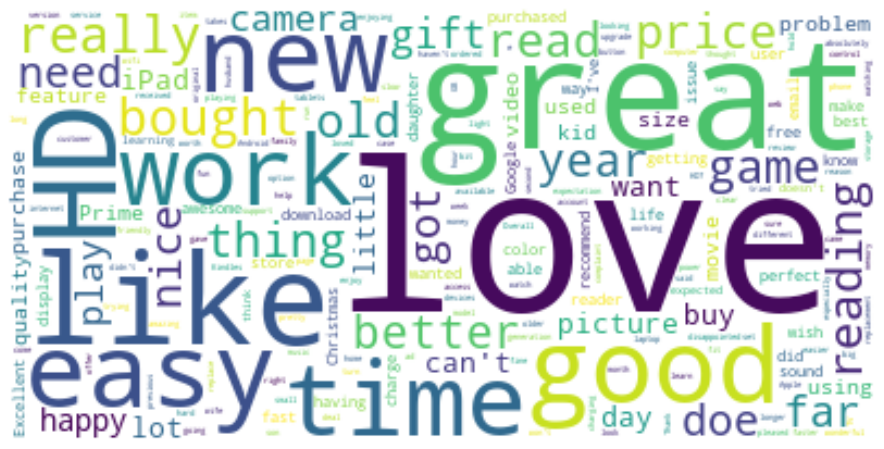

In [11]:
plt.imshow(word_cloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

### Plotting Review Headline WordCloud

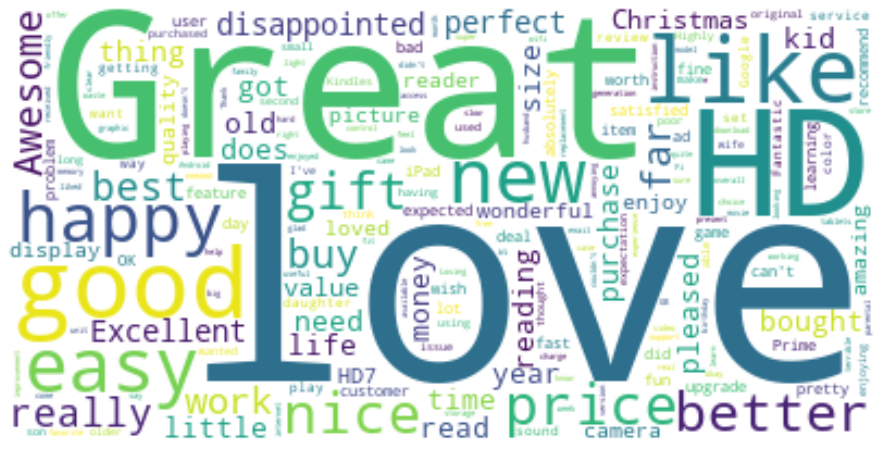

In [12]:
plt.imshow(word_cloud_2, interpolation='bilinear')
plt.axis("off")
plt.show()

From the wordcloud, we can agree to the percentages earlier found that most of the reviews are positive.

<a id='feat'></a>
## Feature Engineering


In [13]:
# create new column containing number of words from each review_body
word_tokens = [word_tokenize(review) for review in data.review_body]
# remove non alphabetic characters in token
clean_tokens = [[word for word in item if word.isalpha()] for item in word_tokens]
length = []
 
for i in range(len(clean_tokens)):
    length.append(len(clean_tokens[i]))
data['no_of_words'] = length  
data.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment,no_of_words
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1,3
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0,30
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1,114
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1,201
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1,8


<a id='model'></a>
## Building the Model

This is a classification problem so a LogisticRegression model will be used.

To build a model, the data has to be transformed to numeric features by using a vectorizer.

In [20]:
# define the vectorizer and specify the arguments
vect = TfidfVectorizer(ngram_range=(1, 3), max_features=500, token_pattern=r'\b[^\d\W][^\d\W]+\b', stop_words=ENGLISH_STOP_WORDS).fit(data.review_body)

# Transform the vectorizer
num_txt = vect.transform(data.review_body)

# Transform to a data frame and specify the column names
num_df=pd.DataFrame(num_txt.toarray(), columns=vect.get_feature_names())
num_df.head()

,ability,able,absolutely,absolutely love,access,account,actually,add,ads,ago,...,works,works great,worth,wouldn,wrong,year,year old,years,yes,youtube
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200803,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344792,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183079,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [23]:
# include the sentiment column which will the label of the model
num_df['sentiment'] = data['sentiment']

num_df.head()

,ability,able,absolutely,absolutely love,access,account,actually,add,ads,ago,...,works great,worth,wouldn,wrong,year,year old,years,yes,youtube,sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.200803,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.344792,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183079,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1


In [22]:
# define target and features
y = num_df.sentiment
X = num_df.drop('sentiment', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Build a logistic regression model and calculate the accuracy
log_reg = LogisticRegression(C = 1.50).fit(X_train, y_train)

# predicting and calculating accuracy
y_predict = log_reg.predict(X_test)
print('Accuracy score of logistic regression: ', accuracy_score(y_test, y_predict))
print('Score of logistic regression: ', log_reg.score(X_test, y_test))

Accuracy score of logistic regression:  0.8946515397082658
Score of logistic regression:  0.8946515397082658
